# Feed-Forward Neural Networks (scikit and keras)

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Image recognition
We consider a classification problem using a dataset of digits

In [2]:
digits = datasets.load_digits()

digits dataset contains a set of handwritten digits represented as $8$-by-$8$ matrices whose entries are digits pixels 

In [3]:
totdigits = digits.images.shape[0]
print('There are {} digits picture represented as {}x{} matrices'.format(totdigits,digits.images.shape[1],digits.images.shape[2]))

There are 1797 digits picture represented as 8x8 matrices


Let us show a sequence of digits

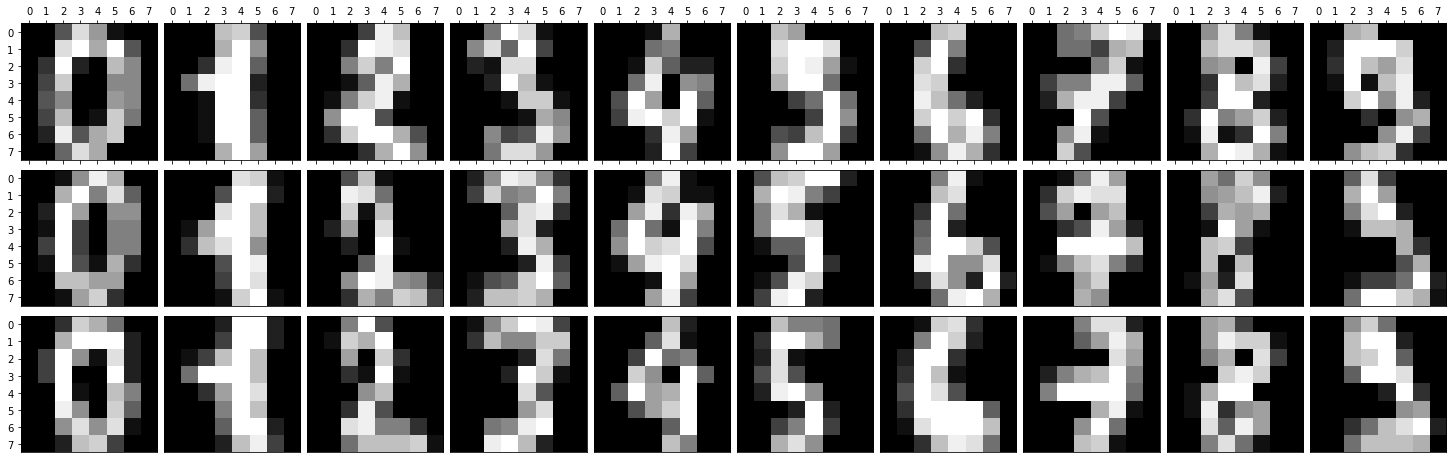

In [4]:
nrows = 3

fig, ax = plt.subplots(nrows, 10, figsize=(20, 6))
plt.gray() # use gray scale
fig.subplots_adjust(left=0.01, right=1, bottom=0, top=1,hspace=0.05, wspace=0.05)
for i in range(nrows):
    for j in range(10):
        ax[i,j].matshow( digits.images[i*10+j] ) 
        if i > 0: ax[i,j].set_xticks([])
        if j > 0: ax[i,j].set_yticks([])
    #endfor
#endfor

### Our task is the image recognition of the digits 

In our case, **the value of each pixel of a digit image is considered as a feature**. 
Given an image of a digit, we represent it as a matrix of pixels and try to predict which right digit it represents (either $0$, $1$,..., or $9$).

First of all, we create a dataframe of digits dataset

In [3]:
# digit dataframe
digdf = pd.DataFrame(data=digits.data)

# add the target label
digdf['digit'] = digits.target

digdf.head(13)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,digit
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0,5
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0,6
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0,9


$i$-th row of the dataframe is digits.data[$i$] (not considering the last entry, which represent the right digit label)

In [6]:
# Double check that there are no Nan entries
colnan = digdf.drop(columns='digit').isnull().sum().sum()
print('total Nan:  {}'.format(colnan))

total Nan:  0


In [7]:
# using seaborn style (type plt.style.available to see available styles) for plots
plt.style.use("seaborn-dark")  

## Multi-Layer Perceptron (MLP from scikit)

In [8]:
from sklearn.neural_network import MLPClassifier

In [9]:
# Train test split (default test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split( digdf.drop(columns="digit").values, 
                                                     digdf['digit'].values, 
                                                     random_state=0 ) 

In [10]:
print( X_train.shape )
print( X_test.shape )

(1347, 64)
(450, 64)


In [11]:
def ffnn_validation(X_train, X_test, y_train, y_test, layers, solv):
    
    n_train_samples = X_train.shape[0]
    n_classes       = np.unique(y_train)
    n_epochs        = 15  
    n_mini_batch    = 200 
    
    # MLPClassifier uses the default "log-loss function" which is the cross-entropy used by keras 
    ffnn = MLPClassifier(activation='relu', alpha=1e-5, verbose=0, tol=1e-8, random_state=1,
                         hidden_layer_sizes=layers, 
                         max_iter = n_epochs, 
                         #batch_size = , #n_mini_batch, 
                         solver = solv)
    trainscore = []
    testscore  = []
                      
    epoch = 0
    while epoch < n_epochs:
                
        # SHUFFLING
        random_perm = np.random.permutation( n_train_samples )
        mini_batch_index = 0
        
        while True:
            # MINI-BATCH
            indices = random_perm[mini_batch_index:mini_batch_index + n_mini_batch]
            # fit
            ffnn.partial_fit(X_train[indices], y_train[indices], classes=n_classes)
            # update 
            mini_batch_index += n_mini_batch

            if mini_batch_index >= n_train_samples:
                break
            #end if
        #end while

        # Train and test score at the end of the epoch
        trainscore.append( ffnn.score(X_train, y_train) )
        testscore.append( ffnn.score(X_test, y_test) )

        # update epoch 
        epoch += 1
    #end while
    
    return ffnn, trainscore, testscore
    
#endfunction

In [12]:
# We build 6 NNs with the following hidden layers
layers0 = (100)
layers1 = (100,100)
layers2 = (50,50,50)
layers3 = (64,32)
layers4 = (128,64,32)
layers5 = (128,64,32,16)

# solver
solv = 'adam'

ffnn0, trainscore0, testscore0 = ffnn_validation(X_train, X_test, y_train, y_test, layers0, solv)
ffnn1, trainscore1, testscore1 = ffnn_validation(X_train, X_test, y_train, y_test, layers1, solv)
ffnn2, trainscore2, testscore2 = ffnn_validation(X_train, X_test, y_train, y_test, layers2, solv)
ffnn3, trainscore3, testscore3 = ffnn_validation(X_train, X_test, y_train, y_test, layers3, solv)
ffnn4, trainscore4, testscore4 = ffnn_validation(X_train, X_test, y_train, y_test, layers4, solv)
ffnn5, trainscore5, testscore5 = ffnn_validation(X_train, X_test, y_train, y_test, layers5, solv)

# store data
models  = [ffnn0, ffnn1, ffnn2, ffnn3, ffnn4, ffnn5] 
trainsc = [trainscore0, trainscore1, trainscore2, trainscore3, trainscore4, trainscore5]
testsc  = [testscore0, testscore1, testscore2, testscore3, testscore4, testscore5]
lays    = [layers0, layers1, layers2, layers3, layers4, layers5]

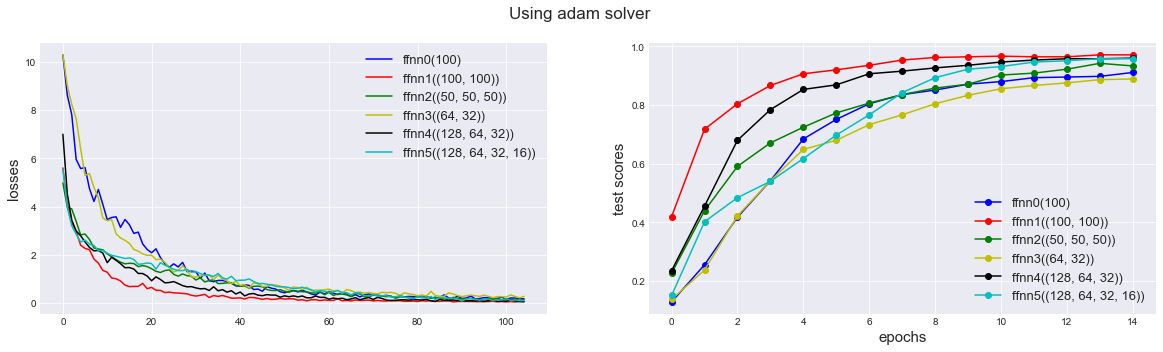

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))

ax[0].plot(ffnn0.loss_curve_, 'b-', label="ffnn0({})".format(layers0))
ax[0].plot(ffnn1.loss_curve_, 'r-', label="ffnn1({})".format(layers1))
ax[0].plot(ffnn2.loss_curve_, 'g-', label="ffnn2({})".format(layers2))
ax[0].plot(ffnn3.loss_curve_, 'y-', label="ffnn3({})".format(layers3))
ax[0].plot(ffnn4.loss_curve_, 'k-', label="ffnn4({})".format(layers4))
ax[0].plot(ffnn5.loss_curve_, 'c-', label="ffnn5({})".format(layers5))
ax[0].set_ylabel('losses',fontsize=15) 
ax[0].legend(fontsize=13)
ax[0].grid()

ax[1].plot(testscore0, 'b-o', label="ffnn0({})".format(layers0))
ax[1].plot(testscore1, 'r-o', label="ffnn1({})".format(layers1))
ax[1].plot(testscore2, 'g-o', label="ffnn2({})".format(layers2))
ax[1].plot(testscore3, 'y-o', label="ffnn3({})".format(layers3))
ax[1].plot(testscore4, 'k-o', label="ffnn4({})".format(layers4))
ax[1].plot(testscore5, 'c-o', label="ffnn5({})".format(layers5))
ax[1].set_ylabel('test scores',fontsize=15) 
ax[1].set_xlabel('epochs',fontsize=15) 
ax[1].legend(fontsize=13)
ax[1].grid()

plt.suptitle('Using {} solver'.format(solv),fontsize=17) 

plt.show()

Let us now plot the test scores and train scores over epochs for all built models

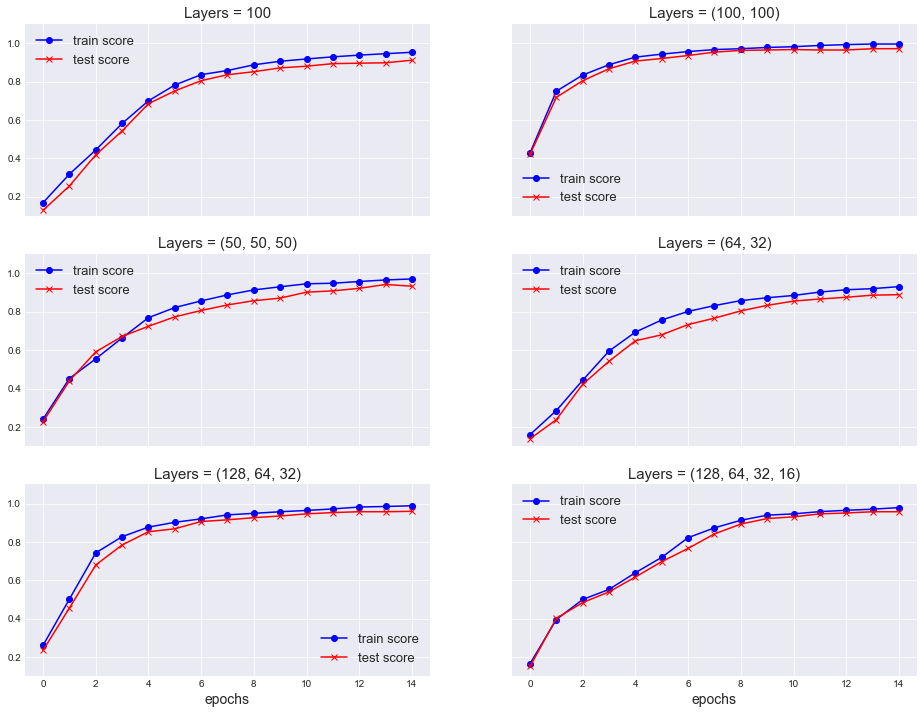

In [14]:
fig, ax = plt.subplots(3,2, figsize=(16, 12), sharey=True, sharex=True)
ax = ax.flatten()

for i in range(6):
    ax[i].plot(trainsc[i], 'b-o', label="train score")
    ax[i].plot(testsc[i],  'r-x', label="test score")
    ax[i].set_title('Layers = {}'.format(lays[i]),fontsize=15) 
    ax[i].set_ylim([0.1,1.1]) 
    ax[i].legend(fontsize=13)
    ax[i].grid()
#endfor 
ax[4].set_xlabel('epochs',fontsize=14) 
ax[5].set_xlabel('epochs',fontsize=14) 
plt.show()

#### Print losses, scores, and confusion matrices

In [15]:
print('\tLoss\t\t\tScores:')
for i in range(6):
    print('ffnn{}:  {}\t{}' .format(i, models[i].loss_curve_[-1], testsc[i][-1] )) 
    

# To obtain the confusio matrix, we make predict using the built models
for i in range(6):
    y_pred = models[i].predict( X_test ) 
    cm = metrics.confusion_matrix( y_test, y_pred ) 
    # notice the final testscore is equal to the percentage of right classifications, 
    # i.e., np.sum(np.diag(cm)) / len(y_test), where cm is the confusion matrix 
    print('\nConfusion matrix (ffnn{})'.format(i))
    print(cm)

	Loss			Scores:
ffnn0:  0.16864749964765927	0.9111111111111111
ffnn1:  0.051562614632894695	0.9711111111111111
ffnn2:  0.12433847349962424	0.9333333333333333
ffnn3:  0.26823803891348197	0.8888888888888888
ffnn4:  0.0518358409768217	0.96
ffnn5:  0.0916025801442497	0.9577777777777777

Confusion matrix (ffnn0)
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  2  1  1  2  1  0]
 [ 2  2 37  2  0  0  0  1  0  0]
 [ 0  0  0 43  0  0  0  0  2  0]
 [ 0  1  0  0 36  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  1  1]
 [ 0  1  0  0  1  0 50  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  0  4  0  1  1  2 35  2]
 [ 0  0  1  0  0  2  0  0  0 44]]

Confusion matrix (ffnn1)
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 42  0  0  0  1  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  1  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  1  0  0 37  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  1]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  2  1  0  0  1  0  0 42  2]
 [ 0  0  0  0  0  0  0  0  0 47]]

Co

## Multi-Layer Perceptron (using keras)

In [4]:
from keras import Sequential, layers, optimizers, losses
from keras.utils import to_categorical

Using TensorFlow backend.


#### Plot facilities

In [5]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")  

def plot_accuracy_and_loss(train_loss, test_loss, train_acc, test_acc, layers):
    fig, ax = plt.subplots(1,2, figsize=(20, 5))
    ax = ax.flatten()

    ax[0].plot(train_loss, 'b-o', label="train")
    ax[0].plot(test_loss,  'r-x', label="test")
    ax[0].set_title('',fontsize=15) 
    ax[0].set_ylabel('loss',fontsize=14) 
    ax[0].set_xlabel('epochs',fontsize=14) 
    ax[0].legend(fontsize=14)
    ax[0].grid()

    ax[1].plot(train_acc, 'b-o', label="train")
    ax[1].plot(test_acc,  'r-x', label="test")
    ax[1].set_title('Layers={}'.format(layers),fontsize=15) 
    ax[1].set_ylabel('accuracy',fontsize=14) 
    ax[1].set_xlabel('epochs',fontsize=14) 
    ax[1].set_ylim([0,1.1])
    ax[1].legend(fontsize=14)
    ax[1].grid()

    plt.show()
#endfunction

# Plot test loss and test accuracy for different models
def plot_accuracy_and_loss_val(hists, layers, lossfun, opt): 
    fig, ax = plt.subplots(1,2, figsize=(20, 5))
    ax = ax.flatten()
    ax[0].set_ylabel('loss',fontsize=14) 
    ax[0].set_xlabel('epochs',fontsize=14) 
    ax[0].grid()
    ax[1].set_ylabel('accuracy',fontsize=14) 
    ax[1].set_xlabel('epochs',fontsize=14) 
    ax[1].grid()
    plt.suptitle('Optimizer: {};    Loss: {}'.format(opt,lossfun),fontsize=17)
    for i in range(len(hists)):    
        ax[0].plot(hists[i].history['val_loss'], '-o', label="layers{}".format(layers[i][1:-1]))
        ax[0].legend(fontsize=14)
        ax[1].plot(hists[i].history['val_acc'], '-o', label="layers{}".format(layers[i][1:-1]))
        ax[1].legend(fontsize=14)
    #endfor
    plt.show()
#endfunction

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split( digdf.drop(columns="digit").values, 
                                                     digdf['digit'].values, 
                                                     random_state=0) 

# To use keras, the vector of labels need to be transformed to categorical data
y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

### Build the neural network
We use: activation=**relu** between hidden layers, activation=**softmax** for the output, mini-batch size=**64**, and epochs=**15**.

In [10]:
def tf_ffnn(X_train, y_train_cat, X_test, y_test_cat, opt, lss, n_units):
    
    # number of feautures
    Nin  = n_units[0]    
    # number of classes (the 10 digits)
    Nout = n_units[-1]
    
    ffnn = Sequential()
    
    # first hidden layer
    ffnn.add( layers.Dense( n_units[1], activation='relu', input_shape=(Nin,) ) )

    # the rest of hidden layers
    for units in n_units[2:-1]:
        ffnn.add( layers.Dense( units, activation='relu' ) )
    # end for

    # last (output) layer
    ffnn.add( layers.Dense(Nout, activation='softmax') )
    
    # compile
    ffnn.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
    
    print('\nFeed-Forward Neural Network (hl={})'.format(n_units[1:-1]))
    ffnn.summary()
    
    # train
    hist = ffnn.fit(x=X_train, y=y_train_cat, batch_size=64, epochs=15, 
                    validation_data=(X_test,y_test_cat), verbose=0)
    
    return hist
#end function

Now we specify the structure of the layers of the neural networks that we are going to build

In [8]:
# number of feautures
Nin  = X_train.shape[1]

# number of outputs labels
Nout = len( np.unique(y_train) )

# We build 6 NNs with the following hidden layers 
n_units0 = [Nin, 100, Nout]
n_units1 = [Nin, 100, 100, Nout]
n_units2 = [Nin, 50, 50, 50, Nout]
n_units3 = [Nin, 64, 128, 64, Nout]
n_units4 = [Nin, 128, 64, Nout]
n_units5 = [Nin, 32, Nout]

# store layers
nunits = [n_units0, n_units1, n_units2, n_units3, n_units4, n_units5]

### Use RMSprop optimizer and cross-entropy loss function

In [16]:
# Using RMSprop and cross entropy
opt = optimizers.rmsprop()
lss = losses.categorical_crossentropy

hists = []
for i in range(len(nunits)):
    hists.append( tf_ffnn(X_train, y_train_cat, X_test, y_test_cat, opt, lss, nunits[i]) )
#endfor


Feed-Forward Neural Network (hl=[100])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1010      
Total params: 7,510
Trainable params: 7,510
Non-trainable params: 0
_________________________________________________________________

Feed-Forward Neural Network (hl=[100, 100])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_40 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_41 (Dense)             (None, 10)                

#### Plot test and train losses and accuracies for each model

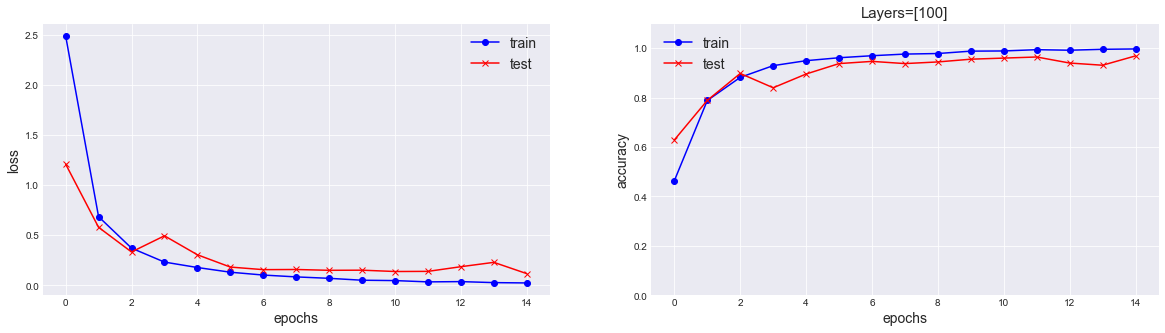

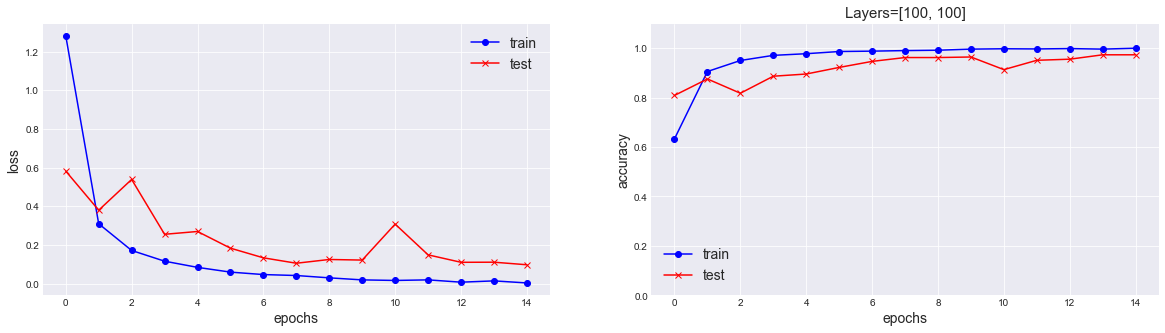

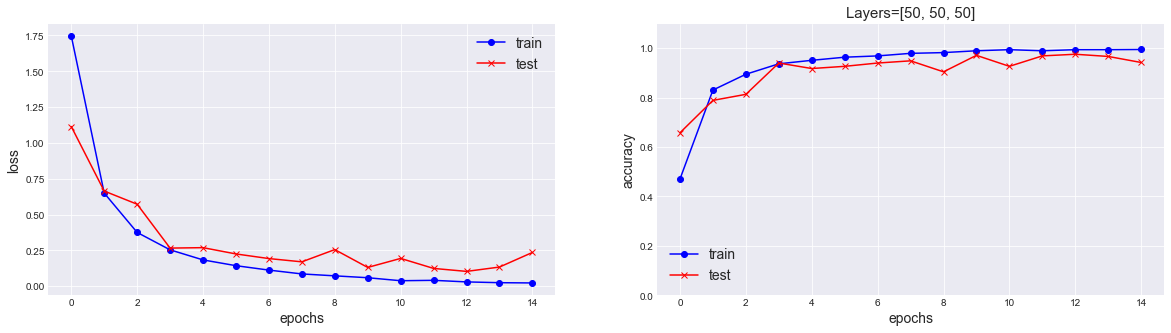

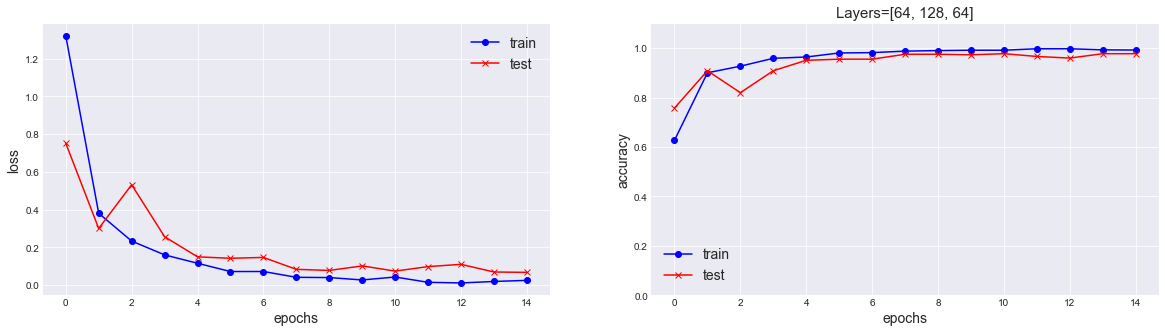

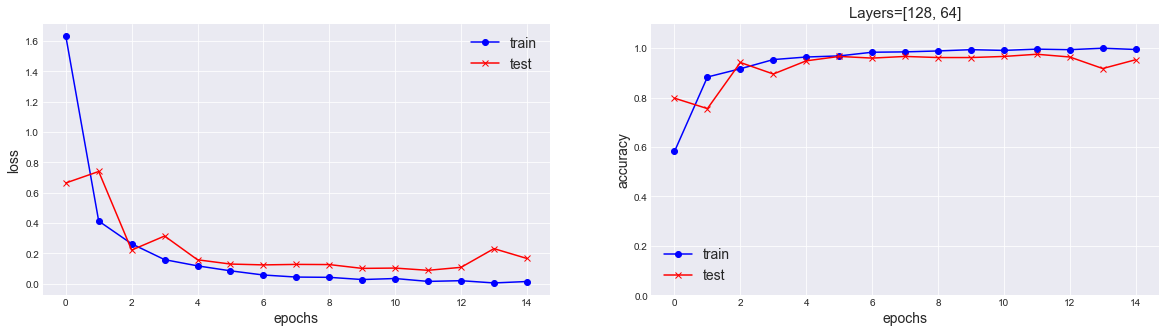

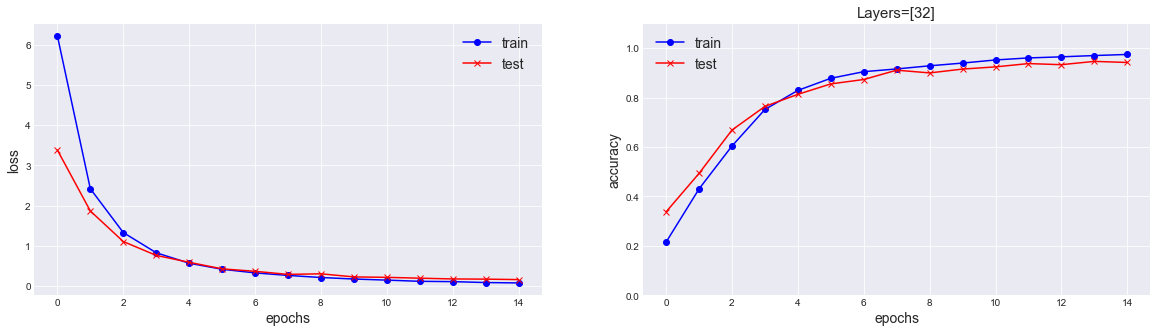

In [17]:
for i in range(6):
    plot_accuracy_and_loss( hists[i].history['loss'],
                            hists[i].history['val_loss'],
                            hists[i].history['acc'],
                            hists[i].history['val_acc'],
                            nunits[i][1:-1])
#endfor

#### and now plot all test loss and accuracies together

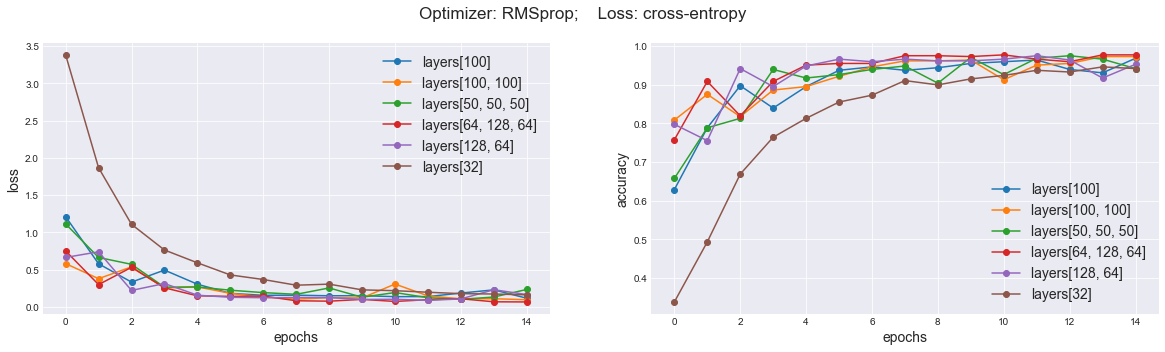

In [18]:
plot_accuracy_and_loss_val(hists, nunits, 'cross-entropy', 'RMSprop')

### Repeat using adam optimizer and mean square error loss function

In [13]:
# Using adam and mean square error
opt = optimizers.adam()
lss = losses.mean_squared_error

hists = []
for i in range(len(nunits)):
    hists.append( tf_ffnn(X_train, y_train_cat, X_test, y_test_cat, opt, lss, nunits[i]) )
#endfor


Feed-Forward Neural Network (hl=[100])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 7,510
Trainable params: 7,510
Non-trainable params: 0
_________________________________________________________________

Feed-Forward Neural Network (hl=[100, 100])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                

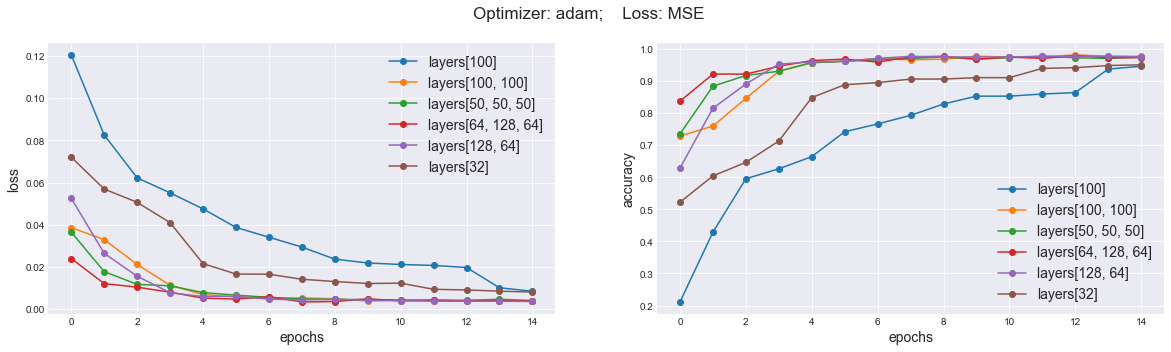

In [15]:
plot_accuracy_and_loss_val(hists, nunits, 'MSE', 'adam')